In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data = pd.read_csv("high_diamond_ranked_10min.csv")
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [20]:
data.shape

(9879, 40)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [22]:
data.nunique()


gameId                          9879
blueWins                           2
blueWardsPlaced                  147
blueWardsDestroyed                27
blueFirstBlood                     2
blueKills                         21
blueDeaths                        21
blueAssists                       30
blueEliteMonsters                  3
blueDragons                        2
blueHeralds                        2
blueTowersDestroyed                5
blueTotalGold                   4739
blueAvgLevel                      17
blueTotalExperience             4143
blueTotalMinionsKilled           148
blueTotalJungleMinionsKilled      74
blueGoldDiff                    6047
blueExperienceDiff              5356
blueCSPerMin                     148
blueGoldPerMin                  4739
redWardsPlaced                   151
redWardsDestroyed                 25
redFirstBlood                      2
redKills                          21
redDeaths                         21
redAssists                        28
r

<Figure size 1080x1080 with 0 Axes>

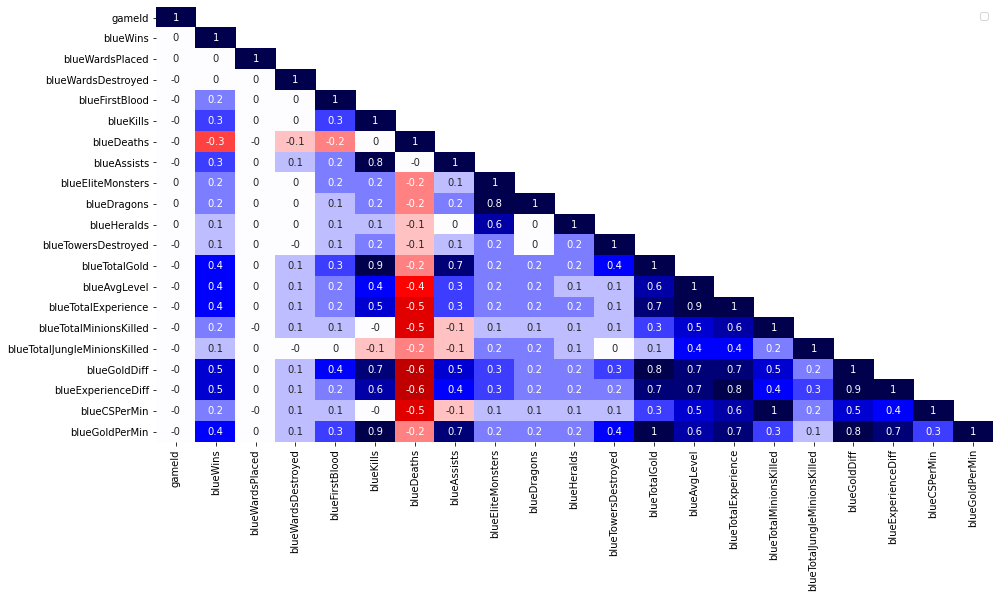

In [23]:
df = data.loc[:,~data.columns.str.startswith('red')]
plt.figure(figsize=(15,15))
corrmat = df.corr()
corrmat = np.tril(corrmat)
corrmat[corrmat==0] = None
corrmat = corrmat.round(1)
labels = df.select_dtypes(include='number').columns.values
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrmat, annot=True, vmax=0.8,vmin=-0.8, cmap='seismic_r', xticklabels=labels,yticklabels=labels, cbar=False)
plt.legend('')

plt.show()

In [29]:
df.blueWardsPlaced.mean()

22.28828828828829

correlation = 1:
blueTotalGold and blueGoldPerMin because all games are exactly 10 minutes in and therefore goldpermin is just totalgold/10
same for totalminionskilled and cs/minute
lets remove the per minute attributes.
lets remove the gameid since it has no correllation to anything
wards placed, the values are very strange, being far too high, we suspect this column is incorrectly labelled and refers to vision score, which measures effectiveness of wards placed, and destroyed (+1 for each minute of ward lifetime gained and +1 for each minute of ward lifetime denied)
both sides have a gold and exp diff column, which are inverses of each other, therefore red diff attributes will be dropped.

Highest correlation to BlueWins:
Golddiff,Expdiff,Totalgold,Totalexp,Avglvl,Kills,Deaths

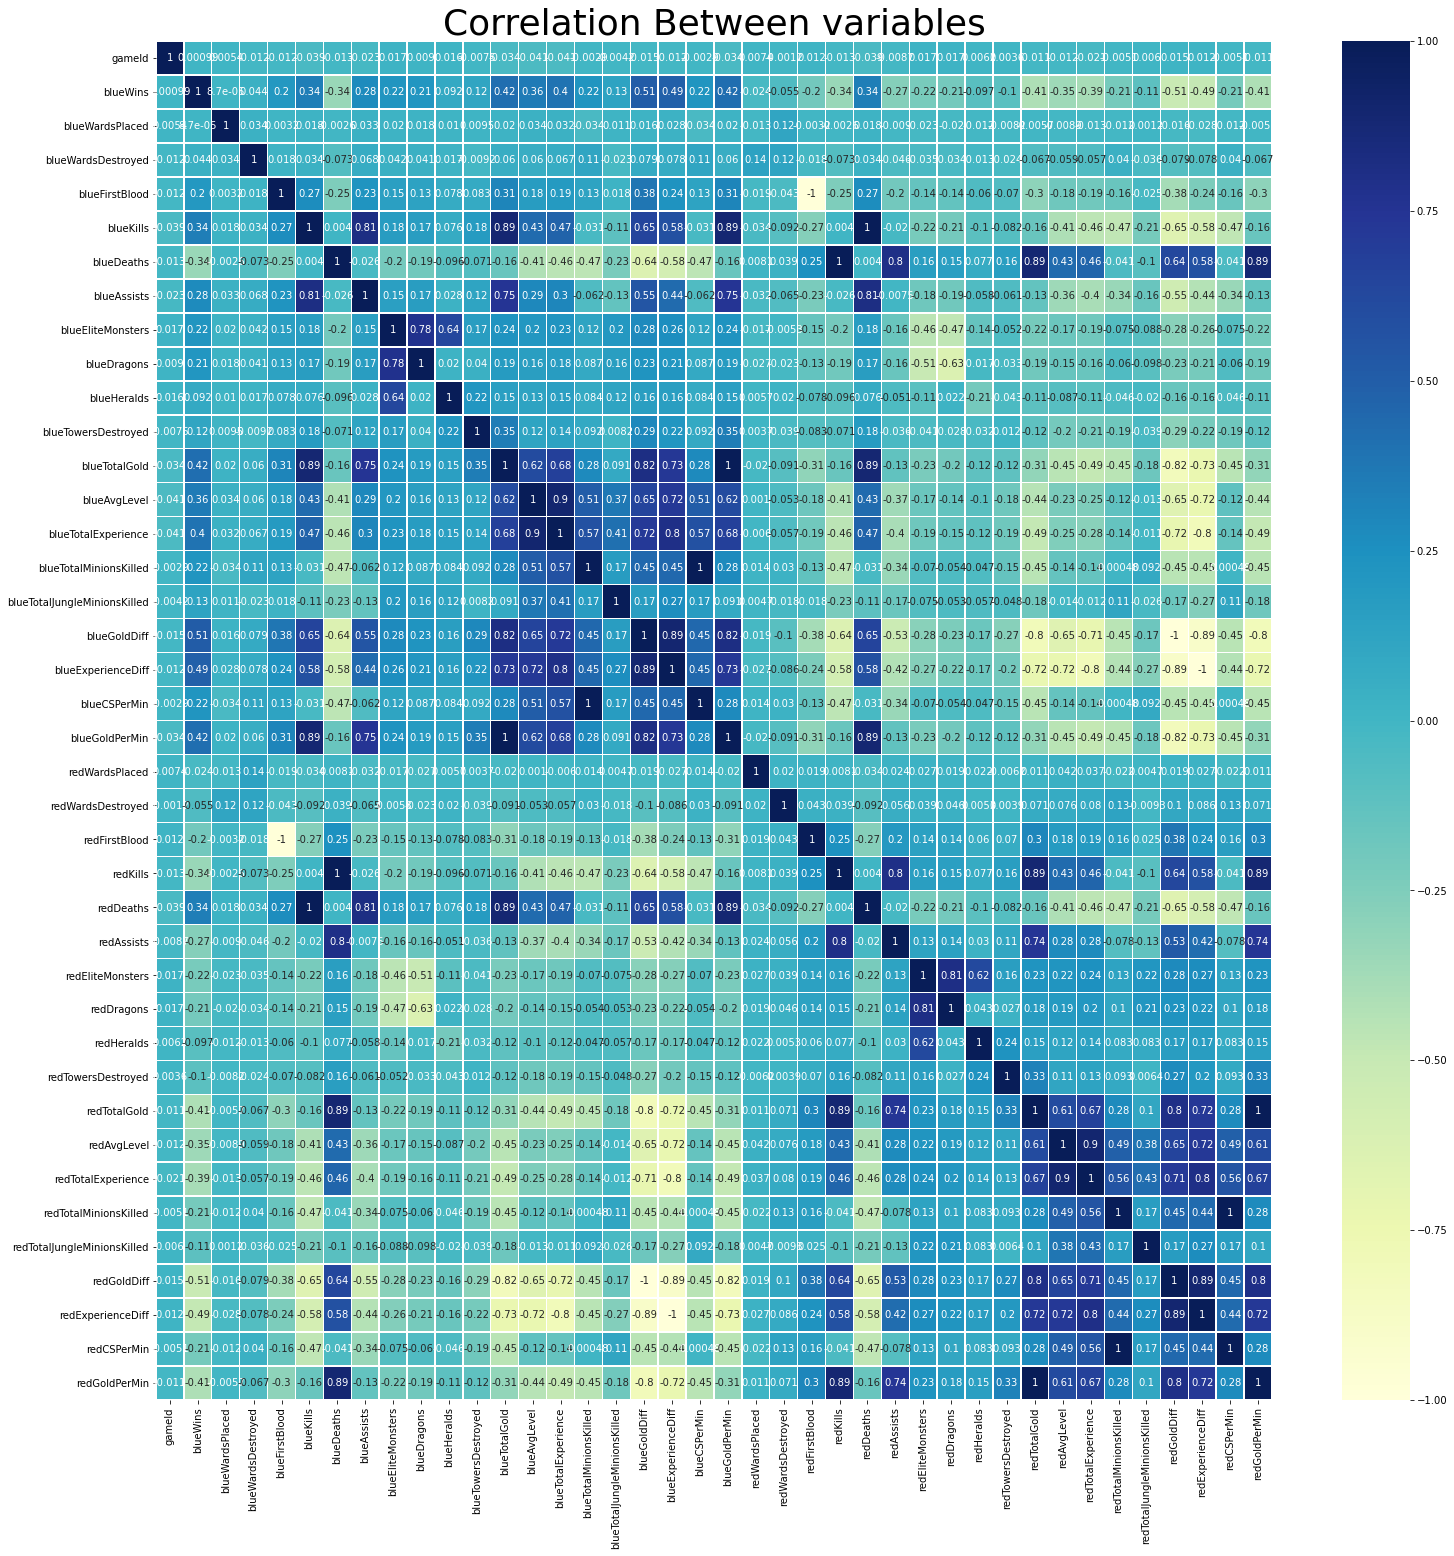

In [31]:
fig , ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(data.corr(), annot=True ,ax=ax, cmap="YlGnBu",linewidths = .5)
ax.set_title("Correlation Between variables", fontsize=36)
plt.show()

In [38]:
data.corr()["blueWins"].sort_values(ascending=False)

blueWins                        1.000000
blueGoldDiff                    0.511119
blueExperienceDiff              0.489558
blueTotalGold                   0.417213
blueGoldPerMin                  0.417213
blueTotalExperience             0.396141
blueAvgLevel                    0.357820
blueKills                       0.337358
redDeaths                       0.337358
blueAssists                     0.276685
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueEliteMonsters               0.221944
blueDragons                     0.213768
blueFirstBlood                  0.201769
blueTotalJungleMinionsKilled    0.131445
blueTowersDestroyed             0.115566
blueHeralds                     0.092385
blueWardsDestroyed              0.044247
gameId                          0.000985
blueWardsPlaced                 0.000087
redWardsPlaced                 -0.023671
redWardsDestroyed              -0.055400
redHeralds                     -0.097172
redTowersDestroy

In [51]:
diff_variables = ['WardsPlaced', 'WardsDestroyed','TotalMinionsKilled', 'Kills', 'Assists', 'EliteMonsters', 'Dragons', 'Heralds', 'TowersDestroyed', 'AvgLevel']
variables_to_drop_red = ['GoldDiff', 'ExperienceDiff']
X_with_fe = pd.DataFrame()
X_with_fe['FirstBlood'] = data['blueFirstBlood']
X_with_fe['blueWins'] = data['blueWins']
for var in diff_variables:
    X_with_fe["{}Delta".format(var)] = data["blue{}".format(var)] - data["red{}".format(var)]

for var in variables_to_drop_red:
    X_with_fe[var] = data["blue{}".format(var)]
X_with_fe.head()

,FirstBlood,blueWins,WardsPlacedDelta,WardsDestroyedDelta,TotalMinionsKilledDelta,KillsDelta,AssistsDelta,EliteMonstersDelta,DragonsDelta,HeraldsDelta,TowersDestroyedDelta,AvgLevelDelta,GoldDiff,ExperienceDiff
0,1,0,13,-4,-2,3,3,0,0,0,0,-0.2,643,-8
1,0,0,0,0,-66,0,3,-2,-1,-1,-1,-0.2,-2908,-1173
2,0,0,0,-3,-17,-4,-10,1,1,0,0,-0.4,-1172,-1033
3,0,0,28,-1,-34,-1,-5,1,0,1,0,0.0,-1321,-7
4,0,0,58,2,-15,0,-1,-1,-1,0,0,0.0,-1004,230


In [52]:
X_with_fe.corr()["blueWins"].sort_values(ascending=False)


blueWins                   1.000000
GoldDiff                   0.511119
ExperienceDiff             0.489558
KillsDelta                 0.479379
AvgLevelDelta              0.452927
AssistsDelta               0.385866
TotalMinionsKilledDelta    0.309126
EliteMonstersDelta         0.259969
DragonsDelta               0.234264
FirstBlood                 0.201769
TowersDestroyedDelta       0.156179
HeraldsDelta               0.121713
WardsDestroyedDelta        0.075205
WardsPlacedDelta           0.016890
Name: blueWins, dtype: float64

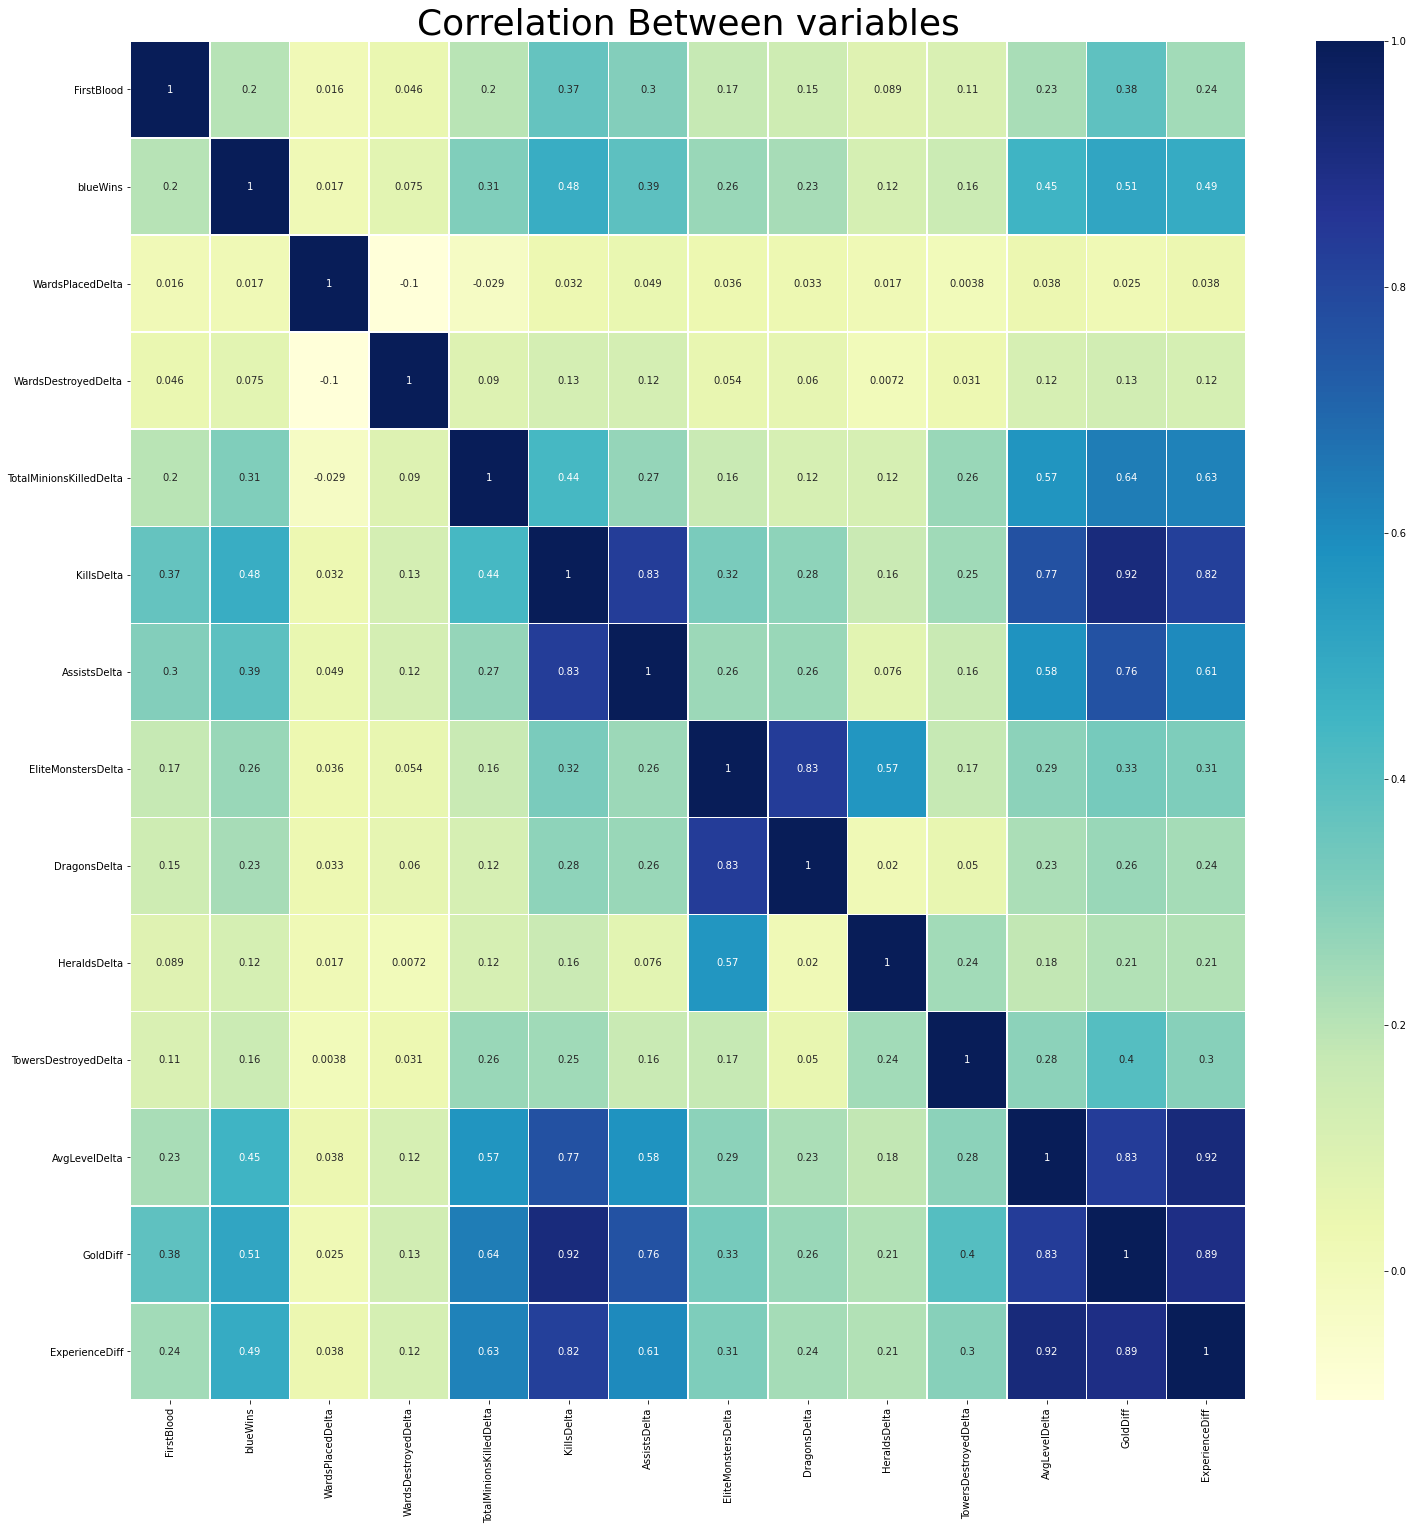

In [53]:
fig , ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(X_with_fe.corr(), annot=True ,ax=ax, cmap="YlGnBu",linewidths = .5)
ax.set_title("Correlation Between variables", fontsize=36)
plt.show()

TODO:
scaling? 
cross validation setup -> Kfold?
lesa meira um pipeline og gridsearchCV
velja model types
gera modelly bois
evaluate the bois
